In [79]:
import numpy as np
from numpy import polyfit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.stats import linregress
from math import floor
from pathlib import Path
import json
from matplotlib.backends.backend_pdf import PdfPages
from uncertainties import ufloat
import uncertainties.unumpy as unp
from glob import glob
import os

import warnings
warnings.filterwarnings("error")


_plot_params = 0
def plot_init( numrows, numcols, axis = True ):
    plt.figure( figsize = ( numcols * 6, numrows * 4  ) )
    global _plot_params
    _plot_params = [ numrows, numcols, 0 ]
    if( axis ):
        plot_next()
def plot_next():
    _plot_params[2] += 1
    plt.subplot( *_plot_params )
def plot_goto( i_row, i_col ):
    _plot_params[2] = i_row * _plot_params[1] + i_col + 1
    plt.subplot( *_plot_params )

In [26]:
# Data saving path
savepath = "A06_results"

## Important routine to summarize all results in a single datafile

No handles with labels found to put in legend.


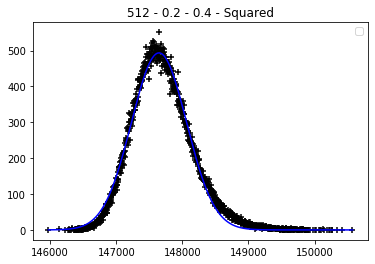

No handles with labels found to put in legend.


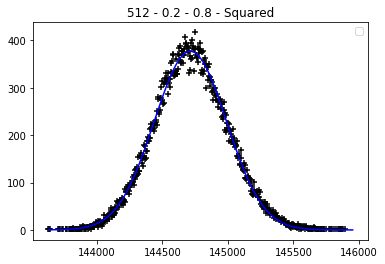

No handles with labels found to put in legend.


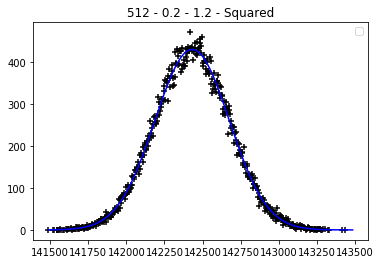

No handles with labels found to put in legend.


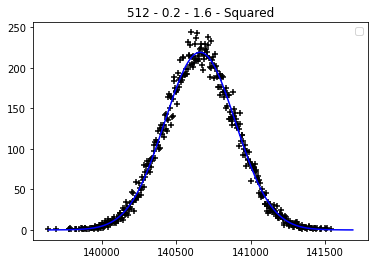

No handles with labels found to put in legend.


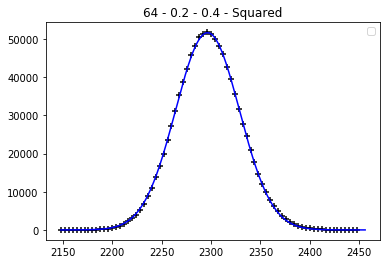

No handles with labels found to put in legend.


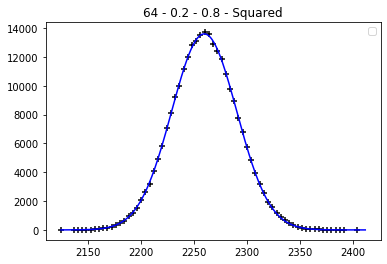

No handles with labels found to put in legend.


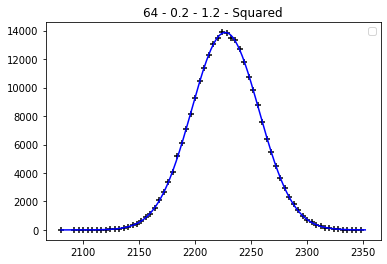

No handles with labels found to put in legend.


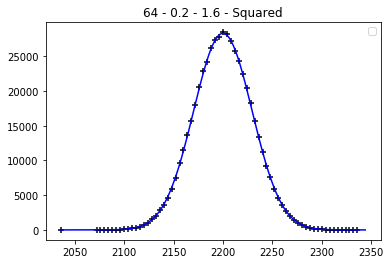

No handles with labels found to put in legend.


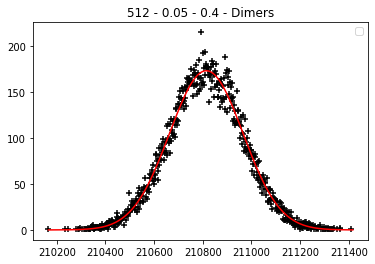

No handles with labels found to put in legend.


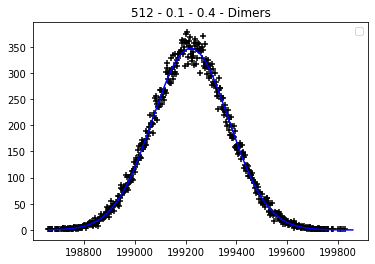

No handles with labels found to put in legend.


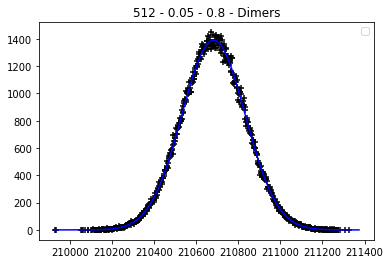

No handles with labels found to put in legend.


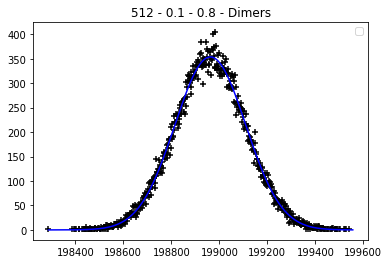

No handles with labels found to put in legend.


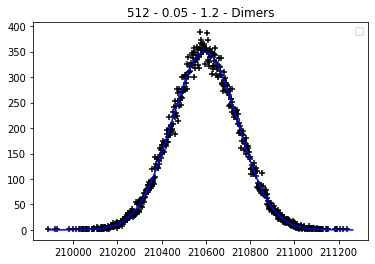

No handles with labels found to put in legend.


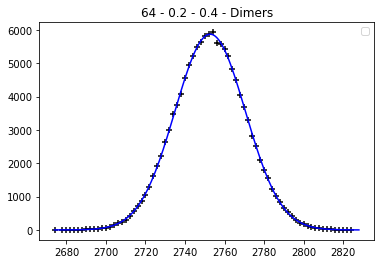

No handles with labels found to put in legend.


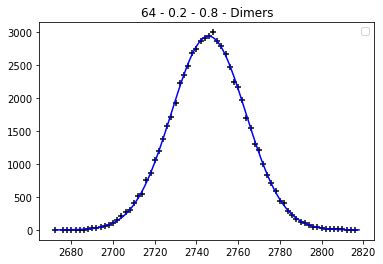

No handles with labels found to put in legend.


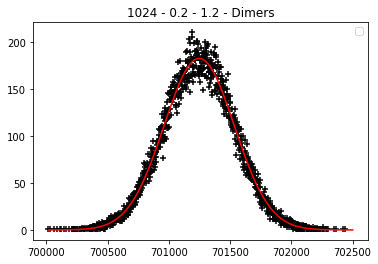

No handles with labels found to put in legend.


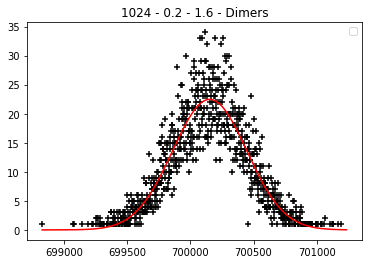

No handles with labels found to put in legend.


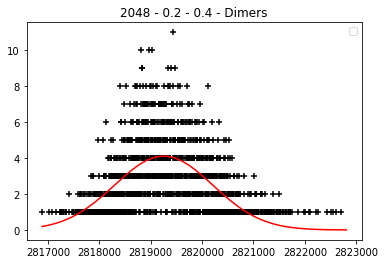

No handles with labels found to put in legend.


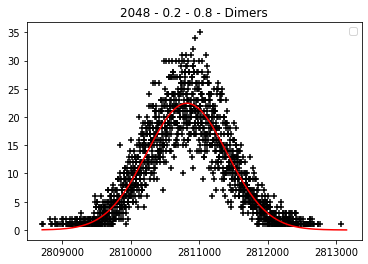

No handles with labels found to put in legend.


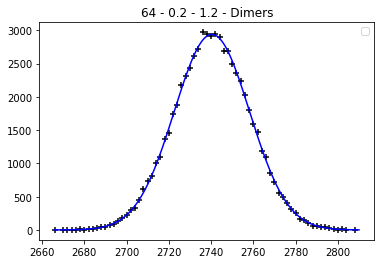

No handles with labels found to put in legend.


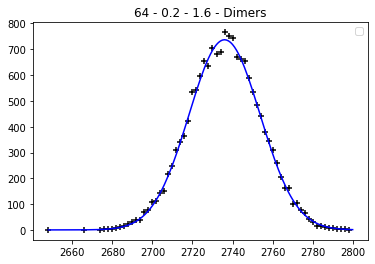

No handles with labels found to put in legend.


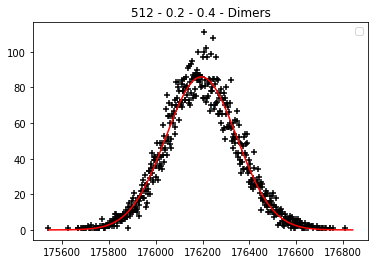

No handles with labels found to put in legend.


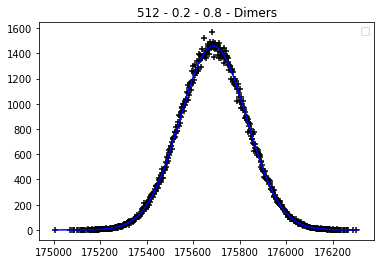

No handles with labels found to put in legend.


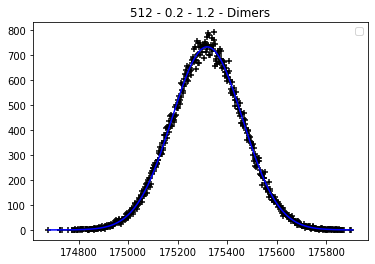

No handles with labels found to put in legend.


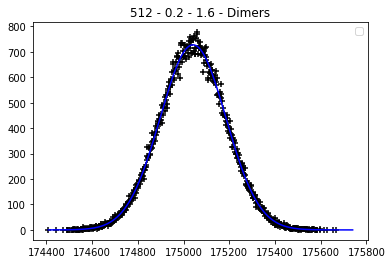

No handles with labels found to put in legend.


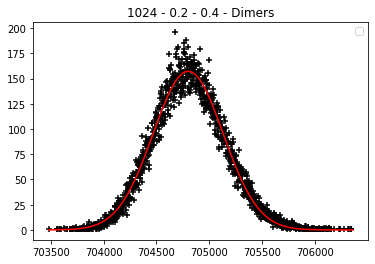

No handles with labels found to put in legend.


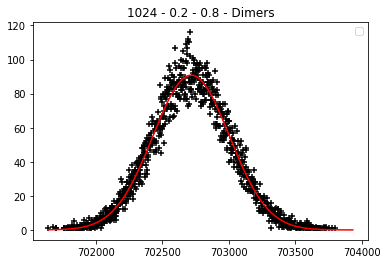

No handles with labels found to put in legend.


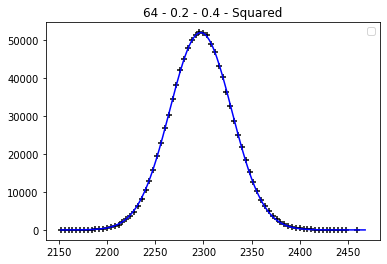

No handles with labels found to put in legend.


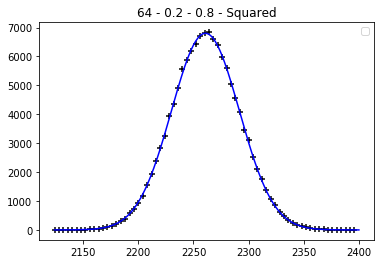

No handles with labels found to put in legend.


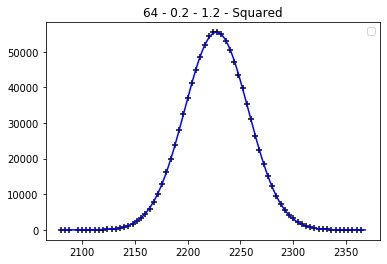

No handles with labels found to put in legend.


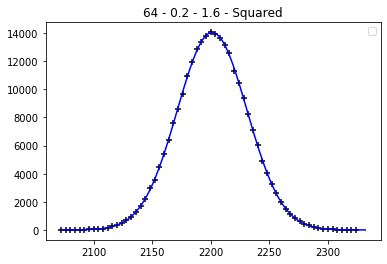

No handles with labels found to put in legend.


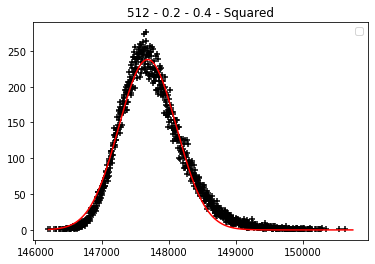

No handles with labels found to put in legend.


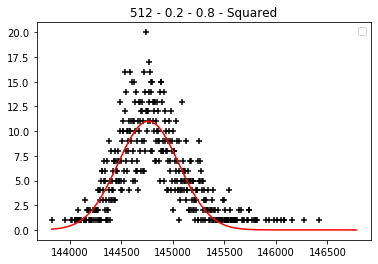

No handles with labels found to put in legend.


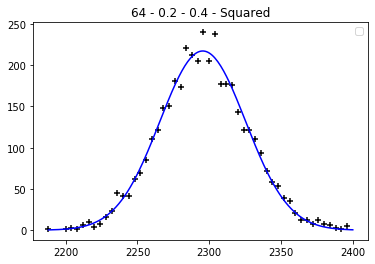

No handles with labels found to put in legend.


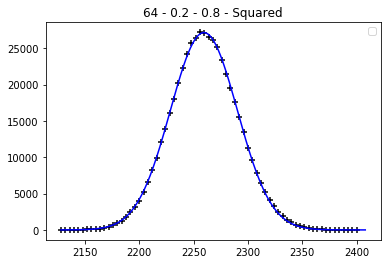

No handles with labels found to put in legend.


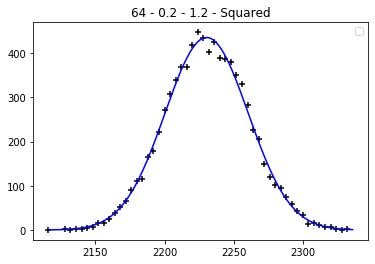

No handles with labels found to put in legend.


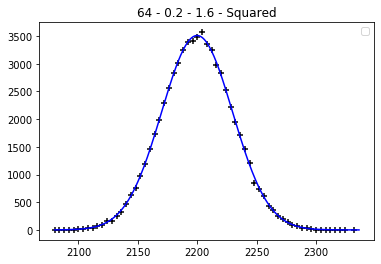

No handles with labels found to put in legend.


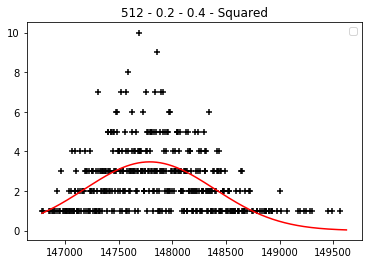

No handles with labels found to put in legend.


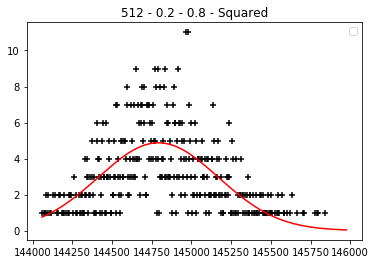

No handles with labels found to put in legend.


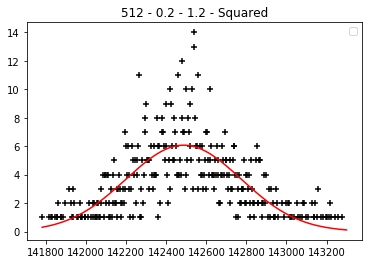

No handles with labels found to put in legend.


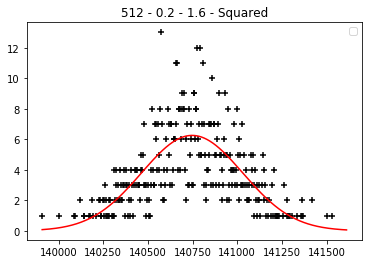

No handles with labels found to put in legend.


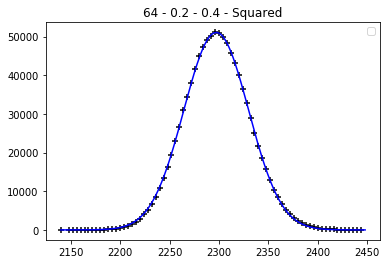

No handles with labels found to put in legend.


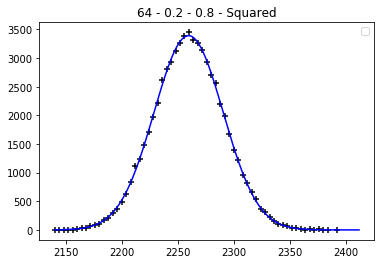

No handles with labels found to put in legend.


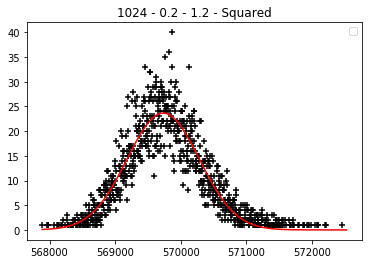

No handles with labels found to put in legend.


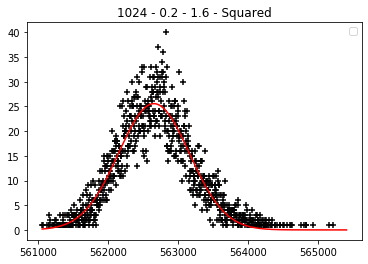

No handles with labels found to put in legend.


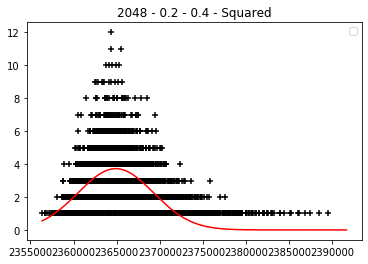

No handles with labels found to put in legend.


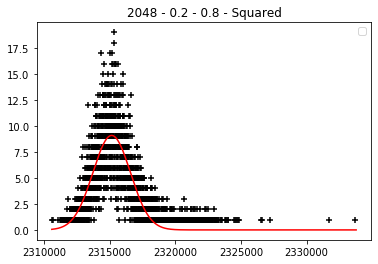

No handles with labels found to put in legend.


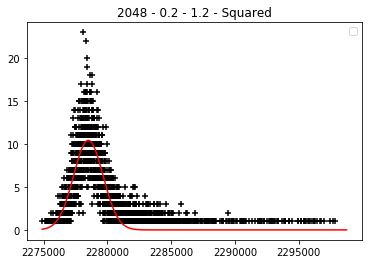

No handles with labels found to put in legend.


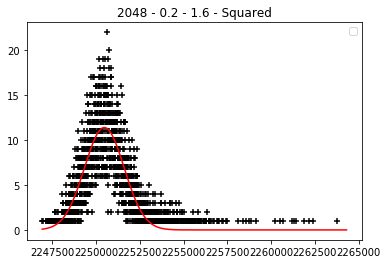

No handles with labels found to put in legend.


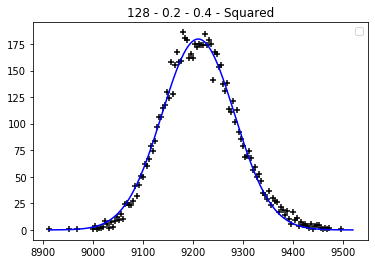

No handles with labels found to put in legend.


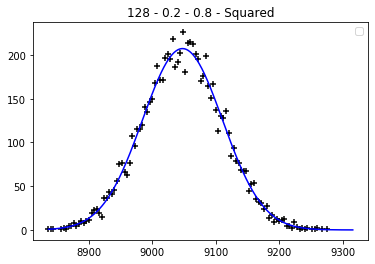

No handles with labels found to put in legend.


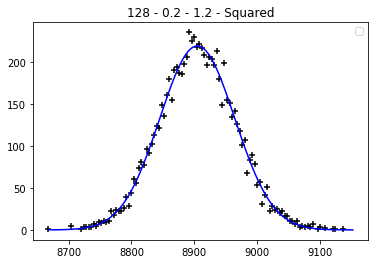

No handles with labels found to put in legend.


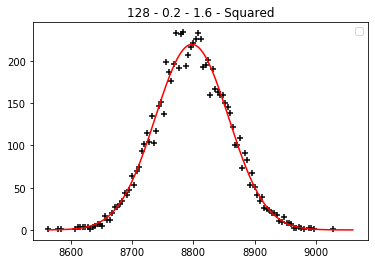

No handles with labels found to put in legend.


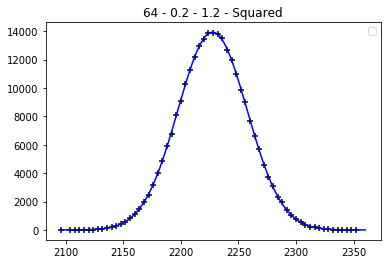

No handles with labels found to put in legend.


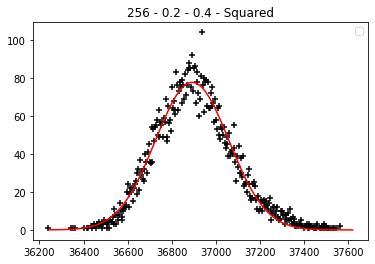

No handles with labels found to put in legend.


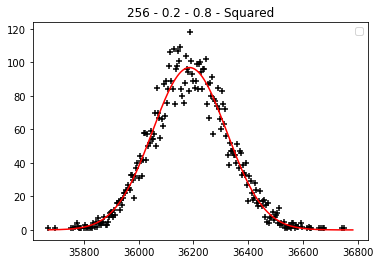

No handles with labels found to put in legend.


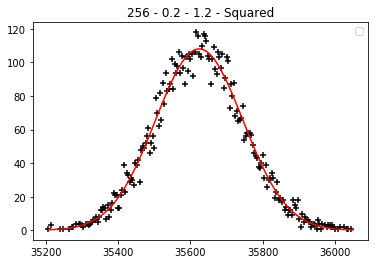

No handles with labels found to put in legend.


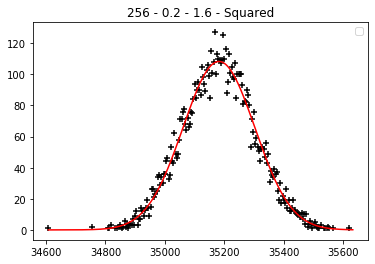

No handles with labels found to put in legend.


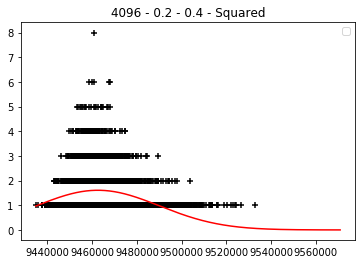

No handles with labels found to put in legend.


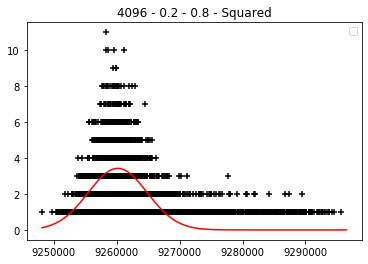

No handles with labels found to put in legend.


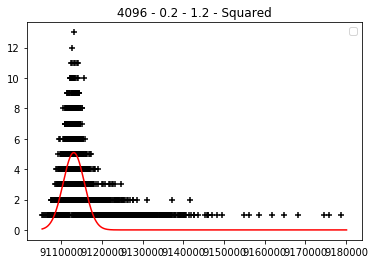

No handles with labels found to put in legend.


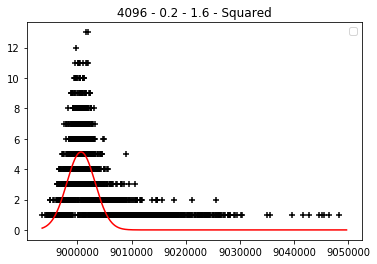

No handles with labels found to put in legend.


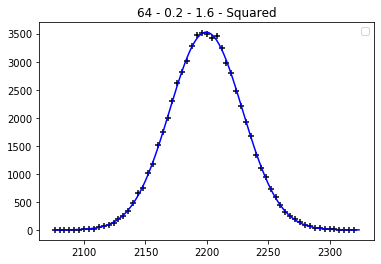

No handles with labels found to put in legend.


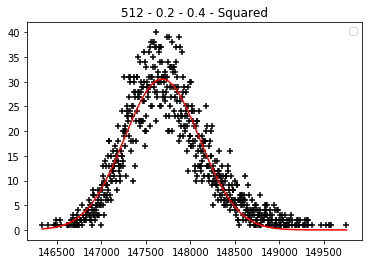

No handles with labels found to put in legend.


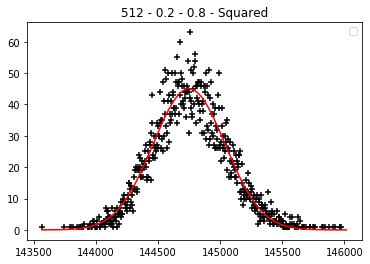

No handles with labels found to put in legend.


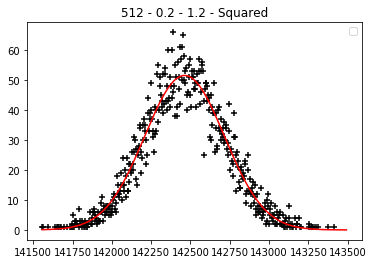

No handles with labels found to put in legend.


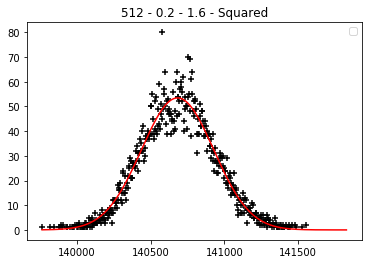

No handles with labels found to put in legend.


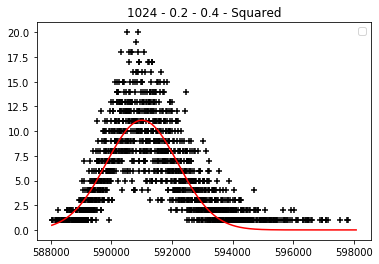

No handles with labels found to put in legend.


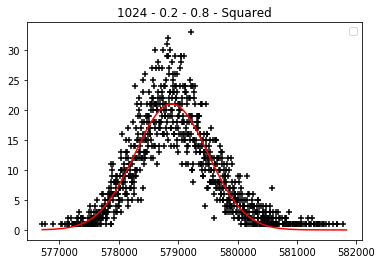

No handles with labels found to put in legend.


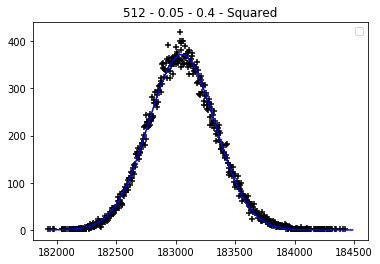

No handles with labels found to put in legend.


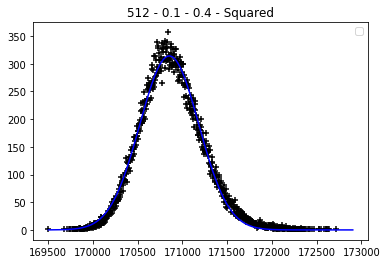

No handles with labels found to put in legend.


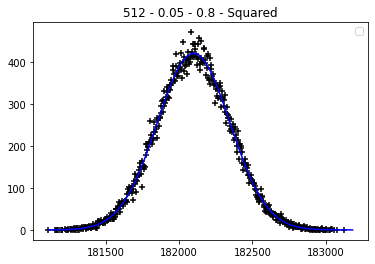

No handles with labels found to put in legend.


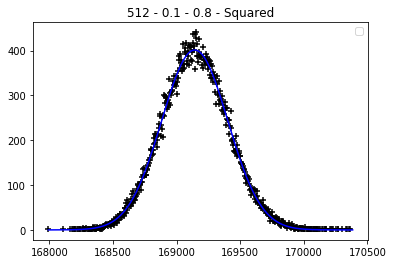

No handles with labels found to put in legend.


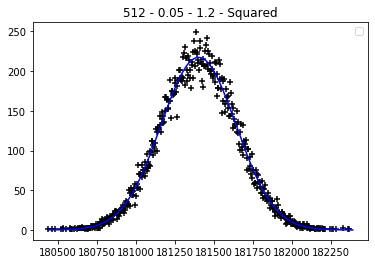

No handles with labels found to put in legend.


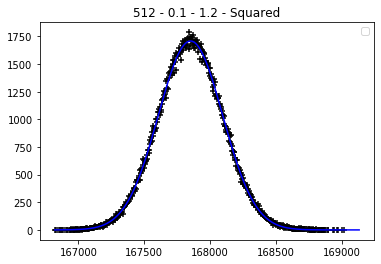

No handles with labels found to put in legend.


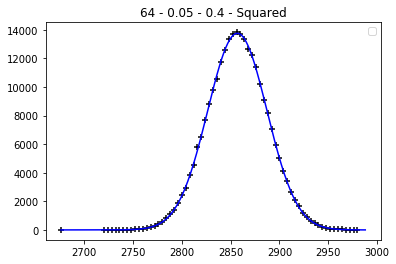

No handles with labels found to put in legend.


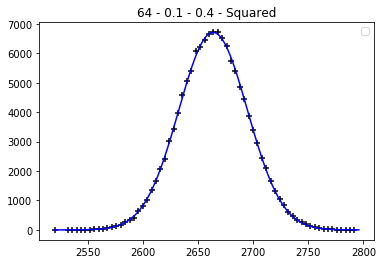

No handles with labels found to put in legend.


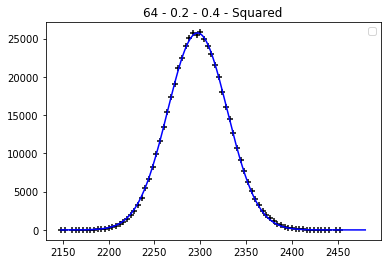

In [75]:
# Load data

def load( filename ):
    text = filename.read_text()
    text = text.replace("nan","0")
    text = text.replace("False", "false" )
    text = text.replace("True", "true" )
    text = text.replace(",]", "]" )
    return json.loads( text )

data = []
computed = []

# # Load the big stuff
# p = Path('../CloudVenetoAnalysis/20220331LowResSquaredscan_20220411/')
# dirs = [f for f in p.iterdir() if f.is_dir()]

compute_from_chunks = True
plot_gauss = True

for file in glob("../*Analysis/**/details.txt", recursive=True):
    item = {}
    d = Path( os.path.dirname( file ) )
    # Verify that everything exists
    if( not (
        ( d / 'details.txt').exists() and
        ( d / 'deposition.txt').exists() and
        ( d / 'percolation.txt').exists() and
        ( d / 'chunks.txt').exists() ) ):
        continue

    item.update( load( d / 'details.txt'     ) )
    item.update( load( d / 'deposition.txt'  ) )
    item.update( load( d / 'percolation.txt' ) )
    
    # Compute occupation fraction std from chunks
    if( compute_from_chunks ):
        with open( d / "chunks.txt" ) as file:
            lines = file.readlines()
            chunks = json.loads( "[" + lines[-1].replace(",]","]").replace("nan","0") + "]" )[-1]
            item['chunks'] = chunks

            x = np.arange( min( chunks ), max( chunks ) + 1 )
            h, _ = np.histogram( chunks, bins= x - 0.5 )

            def Gauss(x, A, mu, s):
                y = A*np.exp(-0.5 * ( ( x - mu ) / s )**2 )
                return y
            (A, mu, s), errs = curve_fit( Gauss, x[:-1][h>0], h[h>0], p0 = [ np.sum(h), np.mean(chunks), np.std(chunks) ])

            item['std_from_fit'] = ufloat( s / ( item['side']**2 ), np.sqrt( errs[2][2] ) / ( item['side']**2 ) )
            item['std_from_np'] = np.std( chunks ) / ( item['side']**2 )
            item['quality_factor'] = np.mean( np.abs( h[h>0] - Gauss( x[:-1][h>0], A, mu, s ) ) ) / A
            item['is_ok'] = ( item['quality_factor'] < 0.03 )

            if( plot_gauss ):
                plt.figure()
                plt.scatter( x[:-1][h>0], h[h>0], marker='+', color='k' )
                plt.plot( x, Gauss( x, A, mu, s ), ('b' if item['is_ok'] else 'r') )
                plt.title( str( item['side'] ) + " - " + str( item['defects_frac'] ) + " - " + str( item['gamma'] ) + " - " + item['dep_polymers'] )
                plt.legend()
                plt.show()

    if( ( not compute_from_chunks ) or item['is_ok']):
        data.append(item)

In [76]:
# useful data
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

polys = np.unique(  [i['dep_polymers'] for i in data] )
sides =  np.unique( [i['side'] for i in data] )
qs =  np.unique( [i['defects_frac'] for i in data] )
gammas =  np.unique( [i['gamma'] for i in data] )
cleaned_data = {}

print( len( data ) )

for p in polys:
    cleaned_data[p] = {}
    for q in qs:
        cleaned_data[p][q] = {}
        for g in gammas:
            cleaned_data[p][q][g] = {}
            for s in sides:
                istance = [ i for i in data if i['dep_polymers'] == p and i['side'] == s and i['defects_frac'] == q and i['gamma'] == g]
                sizes = np.array( [ i['runned_replicas'] for i in istance ] )
                if( len( istance ) > 0 ):
                    cleaned_data[p][q][g][s] = istance[ np.where( sizes == np.amax( sizes ) )[0][-1] ]

                print( p, '\t', '\t', q, '\t', g, '\t', s, '\t',
                    len( istance ), '\t(' , sizes ,')', id
                )


43
Dimers 	 	 0.05 	 0.4 	 64 	 0 	( [] ) 0
Dimers 	 	 0.05 	 0.4 	 128 	 0 	( [] ) 0
Dimers 	 	 0.05 	 0.4 	 512 	 0 	( [] ) 0
Dimers 	 	 0.05 	 0.8 	 64 	 0 	( [] ) 0
Dimers 	 	 0.05 	 0.8 	 128 	 0 	( [] ) 0
Dimers 	 	 0.05 	 0.8 	 512 	 1 	( [262144] ) 0
Dimers 	 	 0.05 	 1.2 	 64 	 0 	( [] ) 0
Dimers 	 	 0.05 	 1.2 	 128 	 0 	( [] ) 0
Dimers 	 	 0.05 	 1.2 	 512 	 1 	( [65536] ) 0
Dimers 	 	 0.05 	 1.6 	 64 	 0 	( [] ) 0
Dimers 	 	 0.05 	 1.6 	 128 	 0 	( [] ) 0
Dimers 	 	 0.05 	 1.6 	 512 	 0 	( [] ) 0
Dimers 	 	 0.1 	 0.4 	 64 	 0 	( [] ) 0
Dimers 	 	 0.1 	 0.4 	 128 	 0 	( [] ) 0
Dimers 	 	 0.1 	 0.4 	 512 	 1 	( [65536] ) 0
Dimers 	 	 0.1 	 0.8 	 64 	 0 	( [] ) 0
Dimers 	 	 0.1 	 0.8 	 128 	 0 	( [] ) 0
Dimers 	 	 0.1 	 0.8 	 512 	 1 	( [65536] ) 0
Dimers 	 	 0.1 	 1.2 	 64 	 0 	( [] ) 0
Dimers 	 	 0.1 	 1.2 	 128 	 0 	( [] ) 0
Dimers 	 	 0.1 	 1.2 	 512 	 0 	( [] ) 0
Dimers 	 	 0.1 	 1.6 	 64 	 0 	( [] ) 0
Dimers 	 	 0.1 	 1.6 	 128 	 0 	( [] ) 0
Dimers 	 	 0.1 	 1.6 	 512 	 

### Delta

$ \Delta \coloneqq \sqrt{ <{ p_j^2 }> - <{ p_j }^2> } $

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


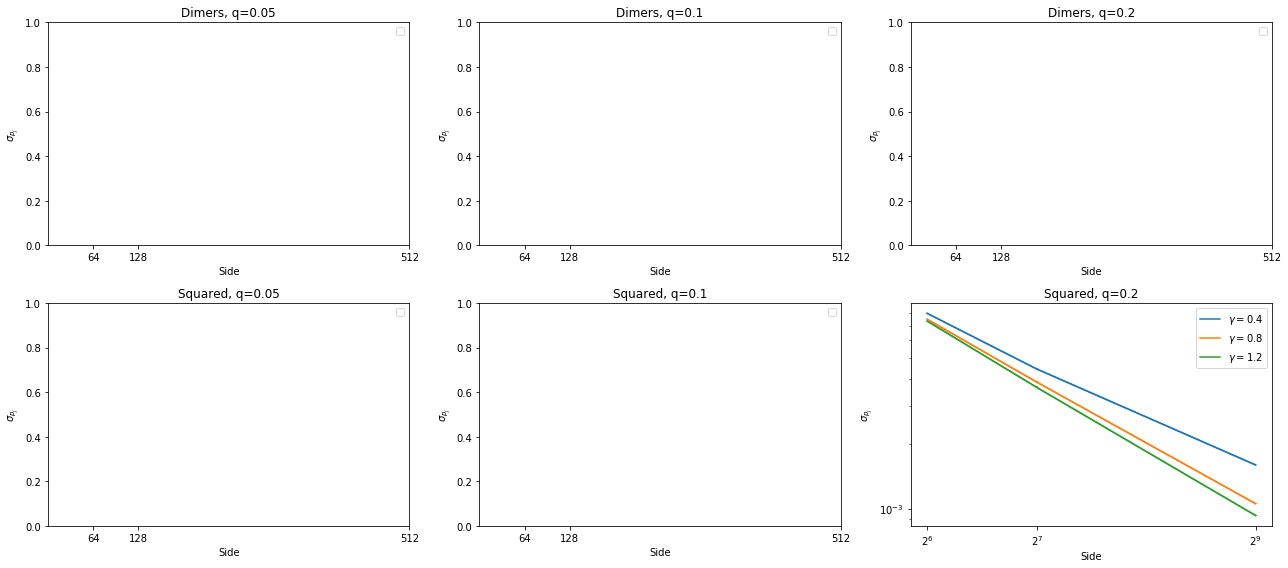

In [87]:
# Jamming density standard deviation as function of L for different values of gamma in different q and different shapes

fig = plot_init( len( cleaned_data ), np.max( [ len( c ) for c in cleaned_data.values() ] ), False )

for i_p, (p, cd_p) in enumerate( cleaned_data.items() ):
    for i_q, (q, cd_p_q) in enumerate( cd_p.items() ):
        plot_goto( i_p, i_q )

        for i_g, (g, cd_p_q_g) in enumerate( cd_p_q.items() ):
            x = [ d['side'] for d in cd_p_q_g.values() ]
            y = [ d['std_from_fit'] for d in cd_p_q_g.values() ]
            if( len( x ) < 3 ):
                continue

            yd= unp.nominal_values( y )
            ye= unp.std_devs( y )

            plt.loglog( x, yd, color=color_list[ i_g ], label= r'$\gamma=$' + str(g), basex = 2, basey = 10 )
            plt.errorbar( x, yd, ye, color=color_list[ i_g ])

        plt.title( p + ", q=" + str(q) )
        plt.legend()
        plt.xlabel(r'Side')
        plt.ylabel(r'$\sigma_{p_j}$')
        plt.xticks( sides )

plt.tight_layout()

plt.savefig( savepath + "/Delta.pdf")

Assume $\Delta(L) = AL^{-1/\nu} + B $

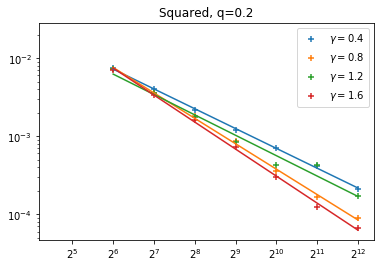

In [24]:
# Fits
field_to_fit = 'occupation_fraction_np'
qsc = qs

fig = plot_init( len( polys ), len( qsc ), False )

ylims_1 = [ 0, 1 ]
ylims_2 = [ 0, 1 ]

fit_results = []

for i_p, p in enumerate( polys ):
    for i_q, q in enumerate( qsc ):
        axes = plot_next()
        for i_gamma, gamma in enumerate( gammas ):
            x = np.array([ v['side']                    for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            y = np.array([ v[field_to_fit] for v in data if v['dep_polymers'] == p and  v['defects_frac'] == q and  v['gamma'] == gamma ])
            
            sort_idx = np.argsort( x )
            x = x[sort_idx]
            y = y[sort_idx]
            lx= np.log2( x )

            ### Initial values
            [menounosunu, log2A], covmat = polyfit( lx, np.log2(y), 1, cov = True )
            B = 0


            ## Iterative fit
            # count = 0

            # while( True ):
            #     prevmenounosunu = menounosunu

            #     ### Fit of B
            #     B = np.mean( y - np.power( 2, menounosunu * lx + log2A ) )
            #     # B = max( min( B, min( y ) - 1e-15  ), 0 ) # ensure is valuable
            #     errB = np.std( y - np.power( 2, menounosunu * lx + log2A ) )

            #     ### Fit for A and menounosunu
            #     [menounosunu, log2A], covmat = polyfit( np.log2(x), np.log2(y - B), 1, cov = True )

            #     ### Check for exit condition
            #     excond = abs( prevmenounosunu - menounosunu ) / min( abs( menounosunu ), abs( prevmenounosunu ) )

            #     if( excond < 1e-7 ):
            #         break

            #     count += 1
            #     print( count, "\t", menounosunu )
            # errmenounosonu = max( np.sqrt( covmat[0,0] ), abs( prevmenounosunu - menounosunu ) )
            # errA: np.sqrt( covmat[1,1] ) * ( 2 ** log2A )

            # Direct fit
            def f( args ):
                (menounosunu, log2A, B) = args
                return np.log2( y - B ) - log2A - menounosunu * np.log2( x )
            temp = least_squares( f, [menounosunu, log2A, B], bounds=( [-np.inf, -np.inf, 0], [0, np.inf, min(y)] ) )
            ( menounosunu, log2A, B ) = temp.x
            cov = np.array( [ [ 0, 0, 0], [ 0, 0, 0], [ 0, 0, 0]] )
            errmenounosonu = np.sqrt( cov[0,0] )
            errA = np.sqrt( cov[1,1] ) * ( 2 ** log2A )


            fit_results.append({
                'gamma': gamma, 'q': q, 'p': p,
                'A': ( 2 ** log2A ), 'unosunu': -menounosunu, 'nu': -1/menounosunu, 'B': B,
                'errA': errA, 'errunosunu': errmenounosonu, 'errnu': errmenounosonu / menounosunu**2, 'errB': errB
            })
            

            # plt.scatter( np.log( x ), np.log( y ) - pars[0] + pars[1] * np.log( x ) )
            plt.scatter( x, y - B, color=color_list[ i_gamma ], label= r'$\gamma=$' + str(gamma), marker='+' )
            plt.plot( x, ( 2 ** log2A ) * ( x ** menounosunu ) )

        plt.xscale( 'log', basex = 2 )
        plt.yscale( 'log', basey = 10 )

        plt.title( p + ", q=" + str(q) )
        plt.legend()
        # plt.xlabel(r'Side')
        # plt.ylabel(r'$\sigma_{p_j}$')
        # plt.xticks( sides )

plt.savefig( 'CriticalExpoF' )
plt.savefig( savepath + "/DeltaFit.pdf")

# plt.tight_layout()
# plt.show()

Exception ignored in: <_io.FileIO name='A04_results_percolation/DeltaFitPars.pdf' mode='wb' closefd=True>


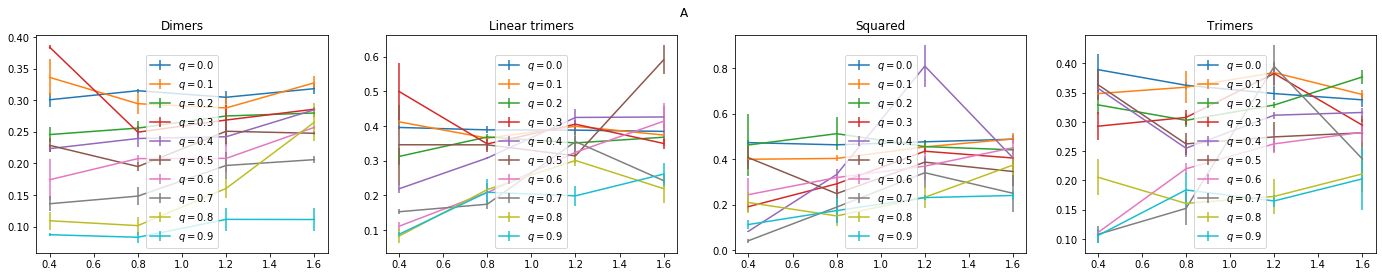

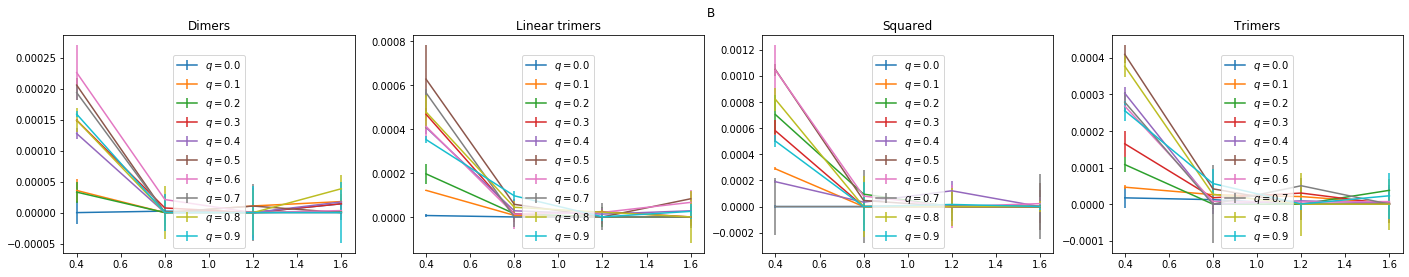

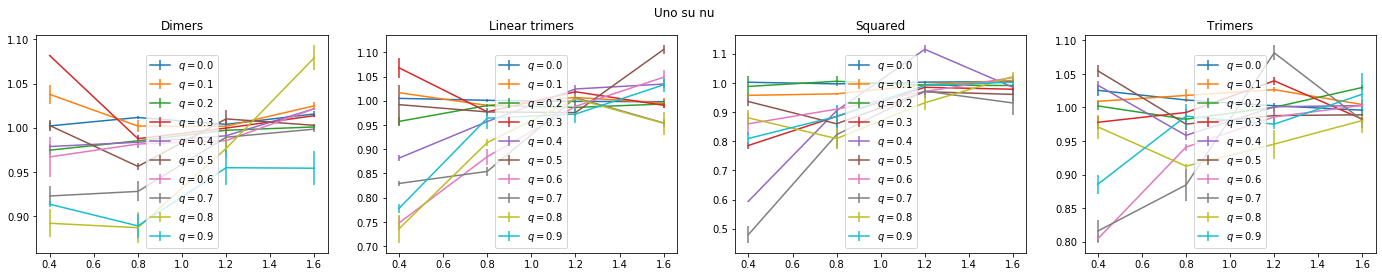

In [23]:
pdf = PdfPages( savepath + "/DeltaFitPars.pdf" )
fig = plot_init( 1, len( polys ), False )

for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y = np.array([ v['A'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry = np.array([ v['errA'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'A')

pdf.savefig()
plt.show()

fig = plot_init( 1, len( polys ), False )
for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['B'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errB'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'B')

pdf.savefig()
plt.show()

fig = plot_init( 1, len( polys ), False )
for i_p, p in enumerate( polys ):
    axes = plot_next( )
    for i_q, q in enumerate( qsc ):
        x   = np.array([ v['gamma']   for v in fit_results if v['p'] == p and  v['q'] == q ])
        y   = np.array([ v['unosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])
        erry= np.array([ v['errunosunu'] for v in fit_results if v['p'] == p and  v['q'] == q ])

        sort_idx = np.argsort( x )
        plt.errorbar( x[sort_idx], y[sort_idx], erry[sort_idx], color=color_list[ i_q ], label= r'$q=$' + str(q) )
    
    plt.title( p )
    plt.legend()
    plt.suptitle( 'Uno su nu')

pdf.savefig()
plt.show()

pdf.close()

##  Percolation studies

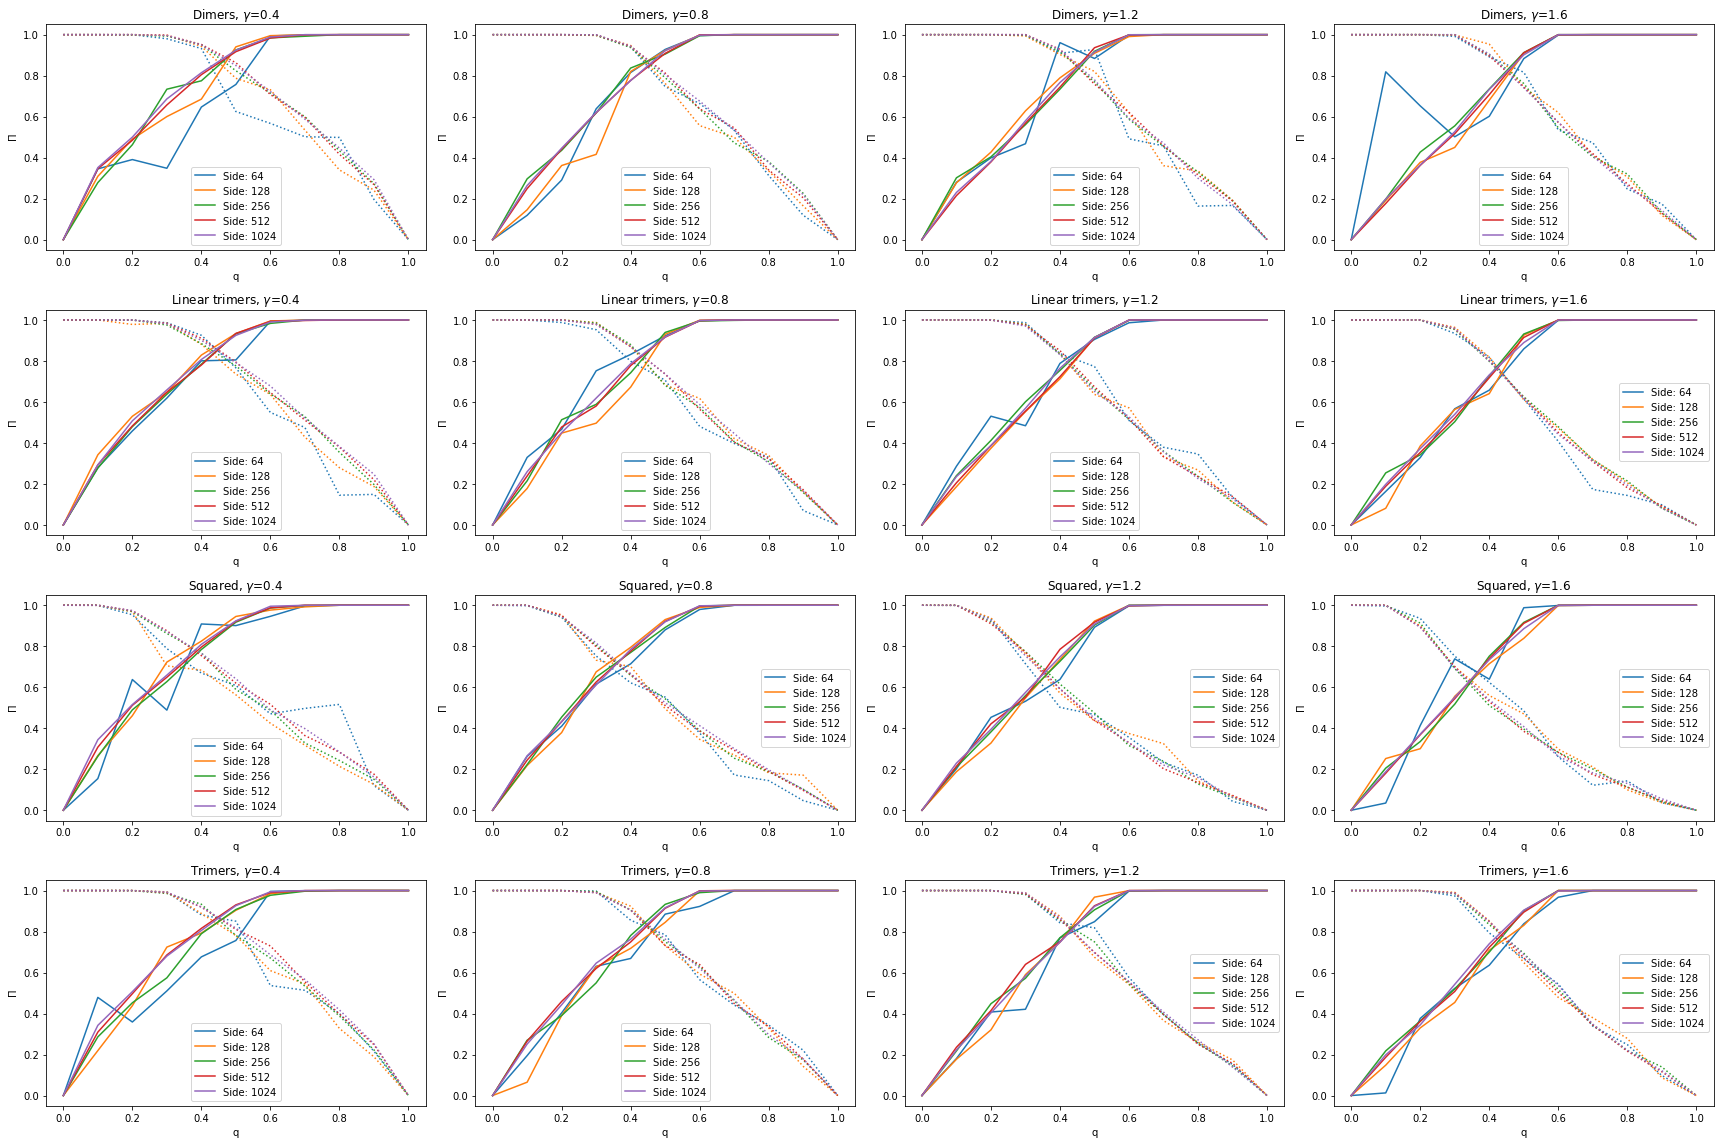

In [12]:
# Percolation probability as function of q for different values of L in different gamma and different shapes

fig = plot_init( len( polys ), len( gammas ), False )

for i_p, p in enumerate( polys ):
    for i_gamma, gamma in enumerate( gammas ):
        axes = plot_next()
        for i_side, side in enumerate( sides ):
            x = np.array([ v['defects_frac'] for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y1= np.array([ v['defperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])
            y2= np.array([ v['atmperc_avg']  for v in data if v['dep_polymers'] == p and  v['gamma'] == gamma and  v['side'] == side ])

            sort_idx = np.argsort( x )
            plt.plot( x[sort_idx], y1[sort_idx], '-', color=color_list[ i_side ], label= f"Side: {side}" )
            plt.plot( x[sort_idx], y2[sort_idx], ':', color=color_list[ i_side ] )
        plt.title( p + r", $\gamma$=" + str(gamma) )
        plt.legend()
        plt.xlabel(r'q')
        plt.ylabel(r'$\Pi$')

plt.tight_layout()